# Initialization

In [1]:
jsoc_email = "david.boils488@topper.wku.edu"
%matplotlib inline

#import torch

import sunpy

import aiapy
import aiapy.data.sample as sample_data
from aiapy.calibrate import normalize_exposure, register, update_pointing

import astropy.units as u
from astropy.coordinates import SkyCoord

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from mpl_toolkits import mplot3d

import numpy as np

import scipy
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from datetime import date

# Set default fig size for matplotlib
plt.rcParams['figure.figsize'] = [8, 8]

# Data Query

In [2]:
start="2012-01-01 00:00:00"
end="2022-01-01 00:00:00"
results = Fido.search(a.Time(start,end), a.hek.FL, a.hek.FL.GOESCls >= "C1.0")
files = Fido.fetch(results)
results.show()

Files Downloaded: 0file [00:00, ?file/s]


gs_thumburl,comment_count,hpc_bbox,frm_humanflag,hgc_coord,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,intensmin,fl_fluence,obs_meanwavel,frm_url,skel_chaincode,bound_chaincode,noposition,fl_fluenceunit,active,intensmax,frm_versionnumber,fl_peaktempunit,fl_halphaclass,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,event_clippedspatial,ar_noaaclass,SOL_standard,event_avg_rating,eventtype,intensunit,hpc_boundcc,event_mapurl,frm_contact,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,boundbox_c2ur,obs_firstprocessingdate,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,ar_mcintoshcls,event_maskurl,bound_ccstartc2,gs_movieurl,event_score,skel_startc2,skel_startc1,fl_efoldtime,event_expires,fl_efoldtimeunit,hrc_boundcc,event_probability,intensvar,frm_daterun,event_coordunit,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,hgs_boundcc,intensskew,obs_includesnrt,rasterscan,obs_wavelunit,kb_archivid,search_frm_name,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,event_importance_num_ratings,ar_compactnesscls,skel_curvature,event_testflag,event_c2error,hrc_r,skel_nsteps,hgs_y,obs_title,fl_peakemunit,hgs_x,hcr_checked,frm_specificid,event_title,obs_instrument,event_c1error,revision,hpc_radius,event_endtime,event_importance,event_coord2,event_coord3,event_coord1,search_observatory,area_raw,concept,event_pixelunit,hgc_boundcc,fl_peakflux,hgc_x,hrc_a,event_peaktime,hgc_y,gs_galleryid,fl_goescls,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,fl_peakfluxunit,fl_peakem,rasterscantype,search_channelid,fl_peaktemp,hgs_bbox,area_unit,obs_lastprocessingdate,refs
str133,str1,str130,str5,str29,str12,object,str30,object,str132,object,str155,str41,str19,str1,str2,object,object,float64,str82,str1,str1,str5,str1,str4,object,object,str1,str1,object,str1,str186,str95,object,str1,str3,str1,str1,str30,object,str1,str1,str1,str1,str23,str1,object,object,str17,object,str9,str24,str1,float64,str1,float64,str61,str110,str1,str1,str1,object,str101,str20,object,object,object,str1,str1,str1,object,object,str19,str7,float64,float64,str6,object,str19,str15,object,str23,str1,object,str1,str1,str2,str74,str17,float64,int32,object,float64,str1,str1,object,str5,int32,float64,object,int32,str1,str1,int32,str5,str1,str1,str6,int32,str3,str20,str19,object,int32,object,int32,str6,object,str5,str1,str1,object,float64,float64,str19,int32,str1,str4,str14,str1,object,object,str1,str1,object,str1,str19,object,str70,str1,str1,object
,0,"POLYGON((-496.1268 -398.5818,-483.4728 -398.1534,-487.6194 -382.5054,-500.3814 -382.938,-496.1268 -398.5818))",false,POINT(79.69593 -26),UTC-HGS-TOPO,None,POINT(-491.9376 -390.5586),None,,None,-,POINT(0.644075102614585 128.446728075923),2012-01-01T07:24:00,,FL,None,None,5e-08,http://www.swpc.noaa.gov/,,,false,,true,None,None,,,None,,01030000000100000005000000D6C56D34806780C0BBB88D06F0787AC0D6C56D34806780C0BBB88D06F05876C0AC8BDB6800AF7CC0BBB88D06F05876C0AC8BDB6800AF7CC0BBB88D06F0787AC0D6C56D34806780C0BBB88D06F0787AC0,"POLYGON((79.19593 -26.5,80.19593 -26.5,80.19593 -25.5,79.19593 -25.5,79.19593 -26.5))",None,,XRA,,,SOL2012-01-01T07:24:00L079C116,None,9,,,,SWPC.Webmaster@noaa.gov,,None,None,SWPC,None,SWPC,GOES,,-25.5,,-26.5,"U.S. Dept. of Commerce, NOAA, Space Weather Prediction Center","POLYGON((0.652566 128.777941,0.642222 129.472412,0.635484 128.111855,0.6461 127.42655,0.652566 128.777941))",,,,None,,0.464000000000000024,None,None,None,,,,None,None,2012-01-01T00:00:00,degrees,-390.5586,-491.9376,GOES,None,2014-05-29T00:34:39,cheung_mark,None,1,,None,,,cm,ivo://helio-informatics.org/FL_SECstandard_20120111_193754_20120101072400,SWPC,-33.5,11389,None,-34.5,,,None,false,1,0.644075102614585,None,-26,,,-34,true,,,GOES,1,3,628.123094884848115,2012-01-01T07:44:00

In [3]:
goes = TimeSeries(files)
hek_results = results['hek']
#hek_results.colnames

In [4]:
bad_bb_rows = 0
flag_bad_coord_sys = False

# Traverse the list backwards so we can just drop rows out of the table 
# without modifying indices of the next element to look at
for idx, row in reversed(list(enumerate(hek_results))):
    if (idx // 100 == idx / 100):
        print(idx)
    if (row["event_coordsys"] != "UTC-HGS-TOPO"):
        # Flag it and drop it
        flag_bad_coord_sys = True
        hek_results.remove_row(idx)
        continue
    # If the bounding box has 0 area or is bigger than 2x2 deg, drop it
    dx = (row["boundbox_c1ur"] - row["boundbox_c1ll"])
    dy = (row["boundbox_c2ur"] - row["boundbox_c2ll"])
    if dx == 0 or dy == 0 or dx > 2 or dy > 2:
        # Drop this row, then move on
        hek_results.remove_row(idx)
        bad_bb_rows += 1

print("Bad bounding box rows: " + str(bad_bb_rows))
print("Bad coord sys?: " + str(flag_bad_coord_sys))

14300
14200
14100
14000
13900
13800
13700
13600
13500
13400
13300
13200
13100
13000
12900
12800
12700
12600
12500
12400
12300
12200
12100
12000
11900
11800
11700
11600
11500
11400
11300
11200
11100
11000
10900
10800
10700
10600
10500
10400
10300
10200
10100
10000
9900
9800
9700
9600
9500
9400
9300
9200
9100
9000
8900
8800
8700
8600
8500
8400
8300
8200
8100
8000
7900
7800
7700
7600
7500
7400
7300
7200
7100
7000
6900
6800
6700
6600
6500
6400
6300
6200
6100
6000
5900
5800
5700
5600
5500
5400
5300
5200
5100
5000
4900
4800
4700
4600
4500
4400
4300
4200
4100
4000
3900
3800
3700
3600
3500
3400
3300
3200
3100
3000
2900
2800
2700
2600
2500
2400
2300
2200
2100
2000
1900
1800
1700
1600
1500
1400
1300
1200
1100
1000
900
800
700
600
500
400
300
200
100
0
Bad bounding box rows: 4291
Bad coord sys?: False


In [5]:
# Traverse the list backwards so we can just drop rows out of the table 
# without modifying indices of the next element to look at
duplicate_rows=0
for idx, row in reversed(list(enumerate(hek_results))):
    if (idx // 100 == idx / 100):
        print(idx)
    # If the start time and end time match another element, drop this one
    for row2 in hek_results[0:idx]:
        if row["event_starttime"] == row2["event_starttime"] and row["event_endtime"] == row2["event_endtime"]:
            # Drop this row, then move on
            hek_results.remove_row(idx)
            duplicate_rows += 1
            break

print("Duplicate rows: " + str(duplicate_rows))
print(hek_results)

10000
9900
9800
9700
9600
9500
9400
9300
9200
9100
9000
8900
8800
8700
8600
8500
8400
8300
8200
8100
8000
7900
7800
7700
7600
7500
7400
7300
7200
7100
7000
6900
6800
6700
6600
6500
6400
6300
6200
6100
6000
5900
5800
5700
5600
5500
5400
5300
5200
5100
5000
4900
4800
4700
4600
4500
4400
4300
4200
4100
4000
3900
3800
3700
3600
3500
3400
3300
3200
3100
3000
2900
2800
2700
2600
2500
2400
2300
2200
2100
2000
1900
1800
1700
1600
1500
1400
1300
1200
1100
1000
900
800
700
600
500
400
300
200
100
0
Duplicate rows: 2728
                                                            gs_thumburl                                                             ...
----------------------------------------------------------------------------------------------------------------------------------- ...
                                                                                                                                    ...
          http://sdowww.lmsal.com/sdomedia/ssw/ssw_client/data/ssw_service_12

In [6]:
# print(hek_results["event_starttime"][2616])
# print(hek_results["event_endtime"][2616])
# print(hek_results["event_peaktime"][2616])
#print(hek_results["fl_goescls"][4140])
# #print(hek_results.colnames)
print(hek_results["boundbox_c1ur"])
print(hek_results["boundbox_c1ll"])
print(hek_results["boundbox_c2ur"])
print(hek_results["boundbox_c2ll"])

boundbox_c1ur
-------------
        -33.5
        -88.0
        -88.0
        -21.0
         90.0
        -19.0
         14.0
         73.0
         17.0
         42.0
          ...
         21.0
         53.0
         23.0
         28.0
         27.0
         14.0
         63.0
         63.0
         63.0
         88.0
         69.0
Length = 7324 rows
boundbox_c1ll
-------------
        -34.5
        -90.0
        -90.0
        -23.0
         88.0
        -21.0
         12.0
         71.0
         15.0
         40.0
          ...
         19.0
         51.0
         21.0
         26.0
         25.0
         12.0
         61.0
         61.0
         61.0
         86.0
         67.0
Length = 7324 rows
boundbox_c2ur
-------------
        -25.5
         12.0
         12.0
        -26.0
          8.0
         19.0
        -17.0
          8.0
         28.0
        -16.0
          ...
         21.0
         30.0
         20.0
         21.0
         20.0
        -15.0
         21.0
         2

# Magnitude Vs. Date

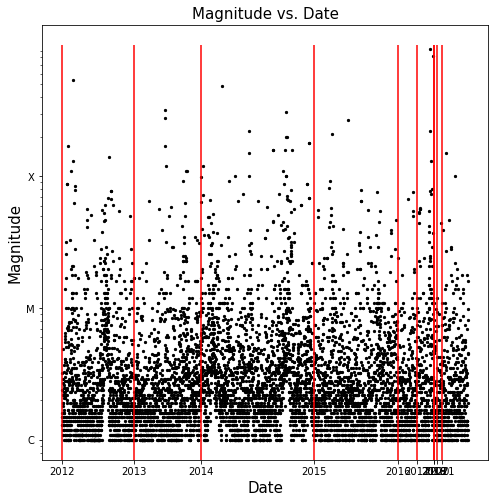

In [7]:
plot=[[],[]] #to carry x and y data for the plot
ticks=[[],[]] #to carry tick data

for i in range(len(hek_results["fl_goescls"])):#loop over our entire set of data
    if(hek_results["event_peaktime"][i][:4]!=hek_results["event_peaktime"][i-1][:4]): #check to see if a new year has occured
        ticks[0].append(i)#save the index
        ticks[1].append(hek_results["event_peaktime"][i][:4])#save the year
        
    plot[0].append(i) #x data
    
    if(hek_results["fl_goescls"][i][:1]=="C"): #scaling the magnitudes for the y data
        plot[1].append(float(hek_results["fl_goescls"][i][1:]))
    elif(hek_results["fl_goescls"][i][:1]=="M"):
        plot[1].append(float(hek_results["fl_goescls"][i][1:])*10)
    elif(hek_results["fl_goescls"][i][:1]=="X"):
        plot[1].append(float(hek_results["fl_goescls"][i][1:])*100)
        
plt.scatter(plot[0],plot[1], s=5, c="k")#plot the data
plt.title("Magnitude vs. Date", fontsize=15)
plt.xlabel("Date", fontsize=15)
plt.ylabel("Magnitude", fontsize=15)
plt.xticks(ticks[0],ticks[1])#make ticks for the years
plt.vlines(x=ticks[0],ymin=0,ymax=1000,colors="r")
plt.yscale("log")# log scale
plt.yticks([1,10,100],["C","M","X"])
plt.show()

In [8]:
temp=0
maximum=0
index=0
for i in range(len(plot[1])):
    temp=plot[1][i]
    if temp>maximum:
        maximum=temp
        index=i
print(index)

6641


# Magnitude vs Date Histogram

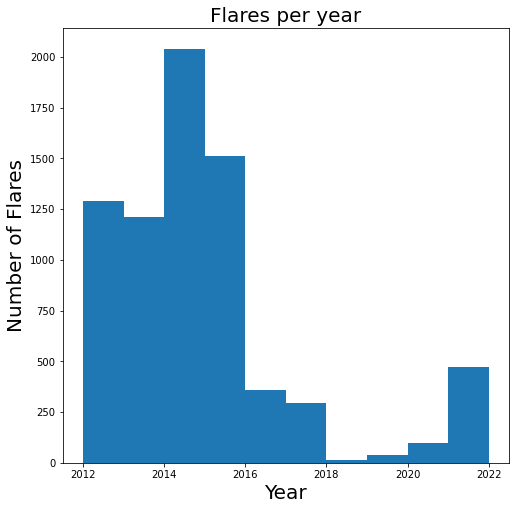

In [7]:
x=[]
for i in range(len(hek_results["fl_goescls"])):#loop over our entire set of data
    x.append(int(hek_results['event_peaktime'][i][:4]))
plt.hist(x,bins=[2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022])
plt.title('Flares per year', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of Flares', fontsize=20)
plt.show()

# Magnitude Vs. Duration

C:\Users\jboil\AppData\Local\Temp/ipykernel_12088/1164516008.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


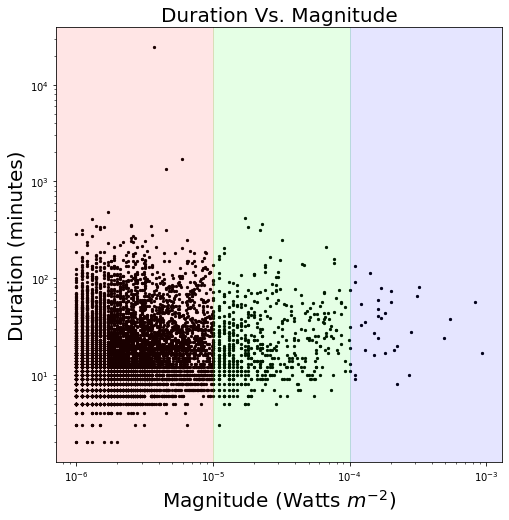

In [9]:
plot=[[],[]] #to carry x and y data for the plot
fig, ax=plt.subplots()
for i in range(len(hek_results[:]["fl_goescls"])):
    
    enddate=date(int(hek_results["event_endtime"][i][:4]),int(hek_results["event_endtime"][i][5:7]),int(hek_results["event_endtime"][i][8:10])) #convert to a date
    startdate=date(int(hek_results["event_starttime"][i][:4]),int(hek_results["event_starttime"][i][5:7]),int(hek_results["event_starttime"][i][8:10]))
    
    duration=enddate-startdate #change in time (days)
    duration=duration.days*24*60 #convert to minutes
    
    duration+=int(hek_results["event_endtime"][i][11:13])*60+int(hek_results["event_endtime"][i][14:16]) #add the difference of the times
    duration-=int(hek_results["event_starttime"][i][11:13])*60+int(hek_results["event_starttime"][i][14:16])
    
    plot[0].append(duration)
    
    
    if(hek_results["fl_goescls"][i][:1]=="C"): #scaling the magnitudes for the y data
        plot[1].append(float(hek_results["fl_goescls"][i][1:]))
    elif(hek_results["fl_goescls"][i][:1]=="M"):
        plot[1].append(float(hek_results["fl_goescls"][i][1:])*10)
    elif(hek_results["fl_goescls"][i][:1]=="X"):
        plot[1].append(float(hek_results["fl_goescls"][i][1:])*100)
        
ax.scatter(plot[1],plot[0], s=5, c='k')#plot the data
ax.set_yscale("log")# log scale
ax.set_xscale("log")
ax.add_artist(pat.Rectangle((0,0),10,5e4, color=(1,0,0,.1)))
ax.add_artist(pat.Rectangle((10,0),90,5e4, color=(0,1,0,.1)))
ax.add_artist(pat.Rectangle((100,0),10000,5e4, color=(0,0,1,.1)))
#plt.xlim(0,500) #due to the outlier at 24625
#plt.xlim(0,1750)
ax.set_title("Duration Vs. Magnitude", fontsize=20)
ax.set_xticks([1,10,100,1000],['$10^{-6}$',"$10^{-5}$","$10^{-4}$",'$10^{-3}$'])
ax.set_ylabel("Duration (minutes)", fontsize=20)
ax.set_xlabel("Magnitude (Watts $m^{-2}$)", fontsize=20)
fig.show()

In [29]:
temp=0
maximum=0
index=0
for i in range(len(plot[1])):
    temp=plot[0][i]
    if temp>maximum:
        maximum=temp
        index=i
print(index)

2616


In [25]:
plot[0][117]

24635

# Magnitude Vs. Area

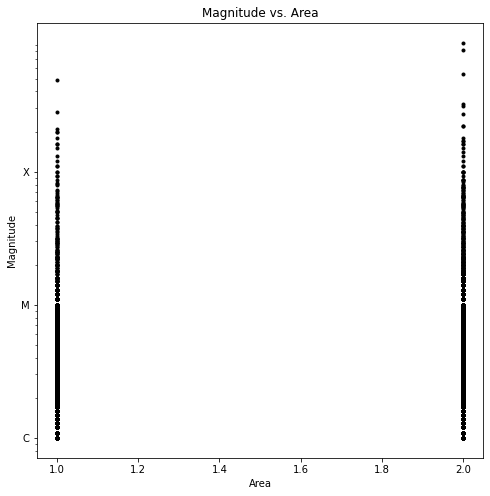

In [10]:
plot=[[],[]] #to carry x and y data for the plot
for i in range(len(hek_results[:]["fl_goescls"])):
    x=float(hek_results["boundbox_c1ur"][i])-float(hek_results["boundbox_c1ll"][i]) #delta x
    y=float(hek_results["boundbox_c2ur"][i])-float(hek_results["boundbox_c2ll"][i]) #delta y
    
    plot[0].append(y)
    
    
    if(hek_results["fl_goescls"][i][:1]=="C"): #scaling the magnitudes for the y data
        plot[1].append(float(hek_results["fl_goescls"][i][1:]))
    elif(hek_results["fl_goescls"][i][:1]=="M"):
        plot[1].append(float(hek_results["fl_goescls"][i][1:])*10)
    elif(hek_results["fl_goescls"][i][:1]=="X"):
        plot[1].append(float(hek_results["fl_goescls"][i][1:])*100)
        
plt.plot(plot[0],plot[1],"k.")#plot the data
plt.yscale("log")# log scale
plt.title("Magnitude vs. Area")
#plt.xlim(0,10)
plt.yticks([1,10,100],["C","M","X"])
plt.xlabel("Area")
plt.ylabel("Magnitude")
plt.show()

# Duration Vs. Area

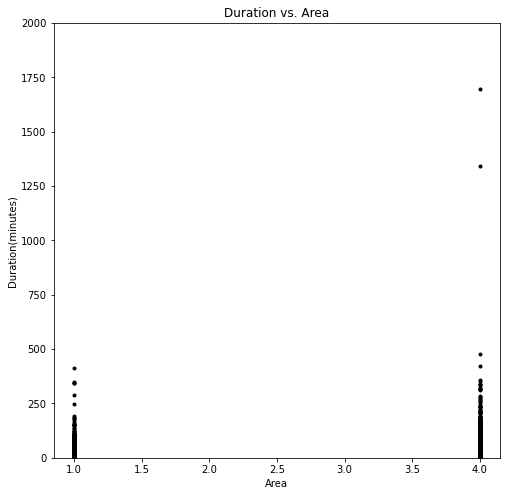

In [11]:
plot=[[],[]] #to carry x and y data for the plot
for i in range(len(hek_results[:]["fl_goescls"])):
    x=float(hek_results["boundbox_c1ur"][i])-float(hek_results["boundbox_c1ll"][i]) #delta x
    y=float(hek_results["boundbox_c2ur"][i])-float(hek_results["boundbox_c2ll"][i]) #delta y
    
    plot[0].append(x*y)
    
     
    enddate=date(int(hek_results["event_endtime"][i][:4]),int(hek_results["event_endtime"][i][5:7]),int(hek_results["event_endtime"][i][8:10])) #convert to a date
    startdate=date(int(hek_results["event_starttime"][i][:4]),int(hek_results["event_starttime"][i][5:7]),int(hek_results["event_starttime"][i][8:10]))
    
    duration=enddate-startdate #change in time (days)
    duration=duration.days*24*60 #convert to minutes
    
    duration+=int(hek_results["event_endtime"][i][11:13])*60+int(hek_results["event_endtime"][i][14:16]) #add the difference of the times
    duration-=int(hek_results["event_starttime"][i][11:13])*60+int(hek_results["event_starttime"][i][14:16])
    
    plot[1].append(duration)
    
        
plt.plot(plot[0],plot[1],"k.")#plot the data
plt.title("Duration vs. Area")
plt.ylim(0,2000)
plt.xlabel("Area")
plt.ylabel("Duration(minutes)")
plt.show()

# Area Vs. Date

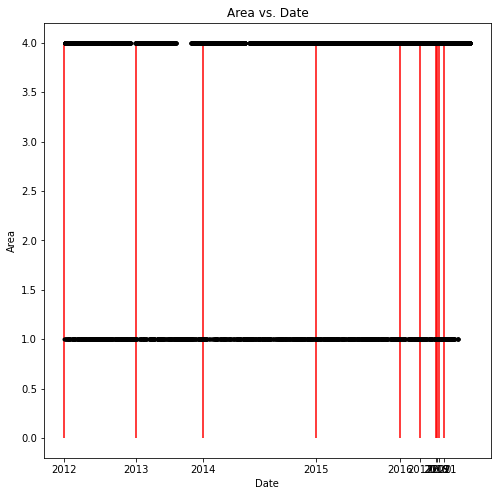

In [15]:
plot=[[],[]] #to carry x and y data for the plot
ticks=[[],[]] #to carry tick data

for i in range(len(hek_results[:]["fl_goescls"])):#loop over our entire set of data
    if(hek_results["event_peaktime"][i][:4]!=hek_results["event_peaktime"][i-1][:4]): #check to see if a new year has occured
        ticks[0].append(i)#save the index
        ticks[1].append(hek_results["event_peaktime"][i][:4])#save the year
        
    plot[0].append(i) #x data
    
    x=float(hek_results["boundbox_c1ur"][i])-float(hek_results["boundbox_c1ll"][i]) #delta x
    y=float(hek_results["boundbox_c2ur"][i])-float(hek_results["boundbox_c2ll"][i]) #delta y
    
    plot[1].append(x*y)
        
plt.plot(plot[0],plot[1],"k.")#plot the data
plt.title("Area vs. Date")
plt.xlabel("Date")
plt.ylabel("Area")
plt.xticks(ticks[0],ticks[1])#make ticks for the years
plt.vlines(x=ticks[0],ymin=0,ymax=4,colors="r")
plt.show()

# Magnitude Vs. Duration Vs. Area

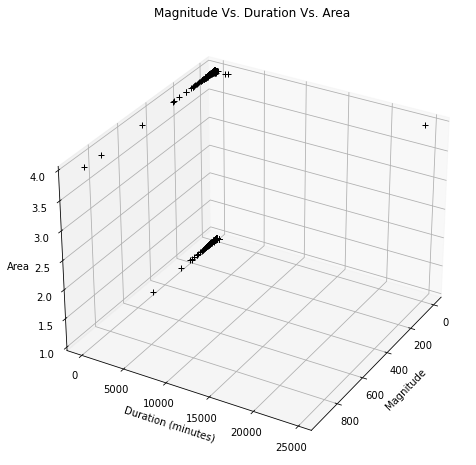

In [17]:
fig = plt.figure()

plot=[[],[],[]]
# syntax for 3-D projection
ax = plt.axes(projection ='3d')

for i in range(len(hek_results[:]["fl_goescls"])):
    
    #Magnitude
    if(hek_results["fl_goescls"][i][:1]=="C"): #scaling the magnitudes for the y data
        plot[0].append(float(hek_results["fl_goescls"][i][1:]))
    elif(hek_results["fl_goescls"][i][:1]=="M"):
        plot[0].append(float(hek_results["fl_goescls"][i][1:])*10)
    elif(hek_results["fl_goescls"][i][:1]=="X"):
        plot[0].append(float(hek_results["fl_goescls"][i][1:])*100)
    
    #Duration
    enddate=date(int(hek_results["event_endtime"][i][:4]),int(hek_results["event_endtime"][i][5:7]),int(hek_results["event_endtime"][i][8:10])) #convert to a date
    startdate=date(int(hek_results["event_starttime"][i][:4]),int(hek_results["event_starttime"][i][5:7]),int(hek_results["event_starttime"][i][8:10]))
    
    duration=enddate-startdate #change in time (days)
    duration=duration.days*24*60 #convert to minutes
    
    duration+=int(hek_results["event_endtime"][i][11:13])*60+int(hek_results["event_endtime"][i][14:16]) #add the difference of the times
    duration-=int(hek_results["event_starttime"][i][11:13])*60+int(hek_results["event_starttime"][i][14:16])
    
    plot[1].append(duration)
    
    #Area
    x=float(hek_results["boundbox_c1ur"][i])-float(hek_results["boundbox_c1ll"][i]) #delta x
    y=float(hek_results["boundbox_c2ur"][i])-float(hek_results["boundbox_c2ll"][i]) #delta y
    
    plot[2].append(x*y)
 
# plotting
ax.plot3D(plot[0], plot[1], plot[2], 'k+')
ax.set_title('Magnitude Vs. Duration Vs. Area')
ax.set_xlabel("Magnitude")
ax.set_ylabel("Duration (minutes)")
#ax.set_ylim(0,1750)
#ax.set_ylim(0,500)
ax.set_zlabel("Area")
#ax.set_zlim(0,1)
ax.view_init(30,30)
plt.show()